# TAA4: Accessibility to healthcare facilities

In this tutorial, we wrap up what you have learned in TAA1-3 by demonstrating their applications and connections. For a European country of your choice, we collect data on the population and their health facilities. Using a classification method, we add rural and urban features to the population data points. Then, with a clustering algorithm, we group population points based on their coordinates and assign each cluster to its closest hospitals. This allows us to calculate the total urban and rural demand for each hospital. Next, we assess the impact of flooding on the hospitals, distinguishing between damaged and undamaged facilities.

In the aftermath of the flood, the number of hospitals in service has changed. Your task will be to repeat the clustering process, assign the new clusters to the intact hospitals, and then calculate their urban and rural demand in the post-flood conditions.

### Important before we start
---
Make sure that you save this file before you continue, else you will lose everything. To do so, go to **Bestand/File** and click on **Een kopie opslaan in Drive/Save a Copy on Drive**!

## Learning Objectives

- To extract, prepare and manipulate geospatial information

- To run a classification algorithm to identify urban and rural land use.

- To overlay raster and vector information.

- To cluster different geospatial layers.

- To visualise geospatial information.
<hr>



## Prepare the packages
<hr>

In [1]:
!pip install -q rasterio rioxarray contextily osm_flex exact_extract

Now we will import these packages in the cell below:

In [2]:
# Standard Library Imports
import os
import sys
from pathlib import Path
from datetime import datetime
from zipfile import ZipFile
from io import BytesIO
import random
import requests
from urllib.request import urlopen

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr

# Machine Learning
import sklearn  # General import if other sklearn modules are needed
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# Geometry and Spatial Analysis
import shapely
from shapely.geometry import Point
import rasterio as rio
from rasterio.enums import Resampling
from scipy.spatial.distance import cdist

# Earth Engine and Geospatial Libraries
import ee
import geemap
import contextily as cx
import osm_flex
from osm_flex import download
from exactextract import exact_extract

# Visualization
import matplotlib.pyplot as plt
import contextily as ctx
from tqdm import tqdm  
from IPython.display import clear_output

## 2. Data download and preparation

Define a country of your interest and a size for gridding and a randomSeed

In [3]:
country_full_name = 'Slovenia'
country_iso3 = 'SVN'
upscale_factor = 10 #Km

### Set global seeds ###
random_seed = 1
np.random.seed(random_seed)
random.seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)

Here, we download the population data from WorldPop, an open source platform. Select the country of interest from the WorldPop [website](https://hub.worldpop.org/geodata/listing?id=62) and add the link to the URL below.

In [4]:
url = "https://data.worldpop.org/GIS/Population/Global_2000_2020/2018/0_Mosaicked/ppp_2018_1km_Aggregated.tif"

file_name = 'ppp_2018_1km_Aggregated.tif'

#open(file_name, 'wb').write(requests.get(url).content)

file_name = "C:\\Data\\Global_Geospatial\\worldpop\\ppp_2018_1km_Aggregated.tif"


world_pop_glob = xr.open_dataset(file_name,engine='rasterio')

Now, we use a file with country borders from Natural Earth, to get boundries of the country of your interest.

In [5]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
# And we want to take the country boundaries and geometry
country_bounds = world.loc[world.ADM0_ISO == country_iso3].bounds
country_geom = world.loc[world.ADM0_ISO == country_iso3].geometry

In [6]:
country_geom

103    POLYGON ((13.64292 45.45943, 13.64282 45.45945...
Name: geometry, dtype: geometry

Now, we use the derived boundries to clip the population data from worldpop, to get the population of our coutnry.

In [7]:
# clip to country
world_pop_national = world_pop_glob.rio.clip_box(minx=country_bounds.minx.values[0],
                     miny=country_bounds.miny.values[0],
                     maxx=country_bounds.maxx.values[0],
                     maxy=country_bounds.maxy.values[0]
                    )
world_pop_national = world_pop_national.rio.clip(country_geom.values, world_pop_glob.rio.crs, drop=False)

The worldpop data, however, is stored as 1km by 1km grid. This will be too computationally intensive if we would use that resolution. As such, we reproject the to a lower resolution. This will help us to perform the analyis more smoothly. We use the *upscale_factor* as defined at the start of this subsection.

In [8]:
new_width = int(world_pop_national.rio.width / upscale_factor)
new_height = int(world_pop_national.rio.height / upscale_factor)

worldpop_Grided = world_pop_national.rio.reproject(
    world_pop_national.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.sum,
)

Now we remove the missing data from our data points and create a GeoDataFrame for our country. 

In [9]:
df_worldpop_ = worldpop_Grided.band_data.to_dataframe()
df_worldpop_ = df_worldpop_.loc[~df_worldpop_.band_data.isna()].reset_index(drop=False)

# create geometry values and drop lat lon columns
df_worldpop_['geometry'] = shapely.points(np.array(list(zip(df_worldpop_['x'],df_worldpop_['y']))))

df_worldpop_ = gpd.GeoDataFrame(df_worldpop_.drop(['y','x','spatial_ref','band'],axis=1))

# dynamically create a variable name for the DataFrame
globals()[f'df_pop_{country_iso3}'] = gpd.GeoDataFrame(df_worldpop_)

# dynamically create a print statement that reflects the current country code
print(f"The output is df_pop_{country_iso3} as a dataframe of the population data of {country_full_name}")

The output is df_pop_SVN as a dataframe of the population data of Slovenia


And Lets plot the population points of our country of interest

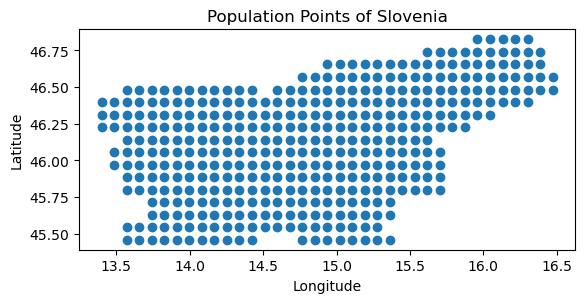

In [10]:
ax = globals()[f'df_pop_{country_iso3}'].plot()
ax.set_title(f'Population Points of {country_full_name}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [11]:
len(globals()[f'df_pop_{country_iso3}'])

396

Our next step is to extract information of healthcare facilities for the country of interest. We do so using OpenStreetMap. With the latest version of geopandas, it is now possible to directly read **osm.pbf** files from OpenStreetMap.

Healthcare facilities are stored as *multipolygons* within OpenStreetMap, and we want to download all clinics and hospitals.

In [12]:
%%time
Country_GeofabrikData_path = download.get_country_geofabrik(country_iso3)

CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
HealthCenters = gpd.read_file(Country_GeofabrikData_path, layer="multipolygons")
sub_types =['clinic', 'hospital']
HealthCenters = HealthCenters[HealthCenters['amenity'].isin(sub_types)].reset_index(drop=True)
HealthCenters = HealthCenters.to_crs(3857)

# to convert polygons to their centroids
HealthCenters_centroids = HealthCenters.copy()
HealthCenters_centroids['geometry'] = HealthCenters.centroid

HealthCenters_centroids=HealthCenters_centroids.to_crs(4326)

C:\Users\eks510\.conda\envs\pygis\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
  return ogr_read(


Let's check the content of our generated HealthCenters_centroids GeoDataFrame.

In [14]:
HealthCenters.head()

,osm_id,osm_way_id,name,type,aeroway,amenity,admin_level,barrier,boundary,building,...,man_made,military,natural,office,place,shop,sport,tourism,other_tags,geometry
0,16172,None,Porodnišnica Ljubljana,multipolygon,None,hospital,None,None,None,hospital,...,None,None,None,None,None,None,None,None,"""addr:city""=>""Ljubljana"",""addr:housenumber""=>""...","MULTIPOLYGON (((1616891.57 5788942.854, 161685..."
1,1735820,None,REHA Radkersburg Klinik Maria Theresia,multipolygon,None,clinic,None,None,None,yes,...,None,None,None,None,None,None,None,None,"""addr:city""=>""Bad Radkersburg"",""addr:housenumb...","MULTIPOLYGON (((1778635.005 5891252.415, 17786..."
2,2226607,None,Univerzitetni rehabilitacijski inštitut Republ...,multipolygon,None,hospital,None,None,None,hospital,...,None,None,None,None,None,None,None,None,"""addr:city""=>""Ljubljana"",""addr:housenumber""=>""...","MULTIPOLYGON (((1616842.545 5791255.347, 16168..."
3,3449006,None,Zdravstveni dom Ljubljana - Rudnik,multipolygon,None,clinic,None,None,None,yes,...,None,None,None,None,None,None,None,None,"""addr:city""=>""Ljubljana"",""addr:housenumber""=>""...","MULTIPOLYGON (((1616791.327 5786197.784, 16167..."
4,5229321,None,Psihiatrična bolnišnica,multipolygon,None,hospital,None,None,None,yes,...,None,None,None,None,None,None,None,None,"""addr:city""=>""Begunje na Gorenjskem"",""addr:hou...","MULTIPOLYGON (((1580944.926 5840918.384, 15808..."


And let's visualize the hospitals locations.

The output is HealthCenters_centroids as a dataframe of the Health Centers


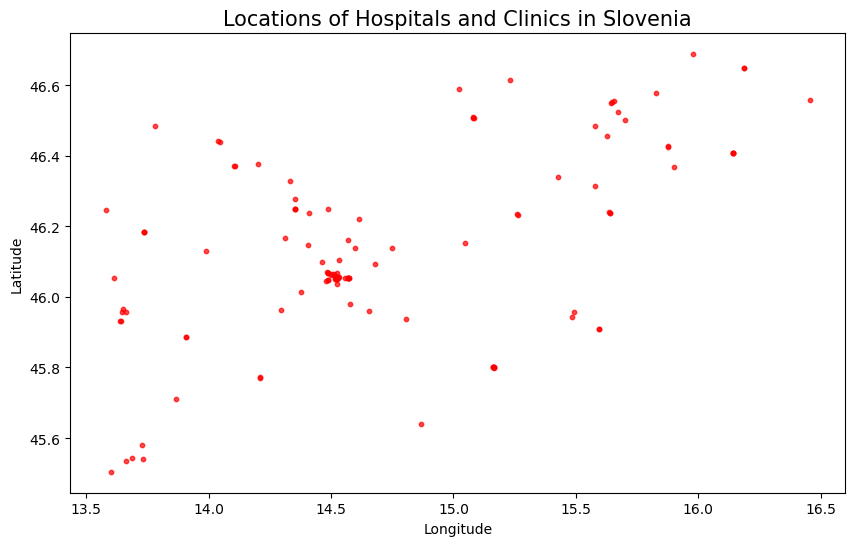

In [15]:
print("The output is HealthCenters_centroids as a dataframe of the Health Centers")

#plotting
fig, ax = plt.subplots(figsize=(10, 10))
HealthCenters_centroids.plot(ax=ax, color='red', markersize=10, alpha=0.7)

# temporarily reprojects to EPSG:3857 to add the basemap (contextily requires it)
#cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik, zoom=8)

ax.set_title(f'Locations of Hospitals and Clinics in {country_full_name}', fontsize=15)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

plt.show()

## 3. Classification of rural and urban areas

As you remember, we checked the content of the population data, and there was no information regarding urban or rural areas. Therefore, we need to add this information to our dataset. So, we will use an approach similar to what you learned in TAA1, but for the sake of processing efficiency, we will use Earth Engine's built-in classifier packages rather than scikit-learn. In this situation we are interested in only two land cover classes: rural and urban. We will have to reclassify the raster, train a model to distinguish between these timesteps, and finally perform the classification on recent images.
<!--  -->
 We have pre-filled most of the code in this section, and you will use a few new tricks to perform the classification. Beyond that, we challenge you to leverage what you have learned in TAA1 to improve the performance of the model, by any means you see fit. You will be evaluated on your reasoning, as well as the creativity of the approaches.

### Set-up

First, set up your Earth Engine environment as you did before.

In [16]:
ee.Authenticate()

True

In [17]:
ee.Initialize(project="proj-gis-1234")

### Set-up training & validation data

We will make use of the following data sources:
1. Administrative country boundary to clip to the area of interest  
2. Sentinel-2 satellite images at 10x10m resolution
3. CORINE Land Cover (CLC)

For the satellite image, we take the S2 median image over the summer to improve sensitivity to single-capture conditions. The median image is taken over the summer, so that we exclude seasonal dynamics. Finally, we clip this image to the country extent.



In [18]:
# Define the region of interest (ROI)
country_ROI = ee.FeatureCollection("FAO/GAUL/2015/level0") \
                .filter(ee.Filter.eq('ADM0_NAME', country_full_name))

# Load Sentinel-2 Image Collection
sentinel2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
             .filterBounds(country_ROI.geometry()) \
             .filterDate('2018-06-01', '2018-08-31') \
             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Create a median composite to reduce cloud cover
mosaic_image = sentinel2.median().clip(country_ROI.geometry())

Show on map to verify that it's loaded

In [19]:
bands = ['B4', 'B3', 'B2'] # Fill in this list yourself
vis_params = {'max': 3000, 'bands': bands}  # Limit upper range so you can see detail

map = geemap.Map(height=800, width=700, zoom=7)

# dynamically center the map on the selected country (ROI)
map.centerObject(country_ROI.geometry(), 8)

# adding the mosaic image layer for the selected country
map.addLayer(mosaic_image, vis_params, "Sentinel-2_2018")

map

Map(center=[46.12445795068446, 14.826893950462633], controls=(WidgetControl(options=['position', 'transparent_…

### Calculate image variables to include

Next, we will compute variables to use for our classifier. We have provided the examples you've already seen for TAA1, but we challenge you to add your own variables. You can get inspiration from anywhere, but be sure that you are able to explain the reasoning behind including each variable.

In [20]:
def make_s2_variables(s2_image):
    # Calculate additional spectral indices
    dvi = s2_image.select('B5').subtract(s2_image.select('B4')).rename('DVI')
    ndvi = s2_image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi = s2_image.normalizedDifference(['B3', 'B5']).rename('NDWI')

    # Add indices to the image
    s2_image = s2_image.addBands([dvi, ndvi, ndwi])

    '''
       ToDo: Add your own variables!

       Think about what you learned in TAA1 - how else can you compute information
       from the spectral bands to include? Look at some papers for inspiration,
       or try something out yourself. There's more than just indices that can help here!

       Don't forget to add them to the image after you create them!
    '''
    ### TEACHER EXAMPLE - REMOVE BEFORE GOES LIVE. ###

    # Define neighborhood size (e.g., 3x3)
    kernel = ee.Kernel.square(radius=1)

    # Calculate neighborhood statistics
    neighborhood_vars = []
    for band in ['DVI', 'NDVI', 'NDWI']:
        mean = s2_image.select(band).reduceNeighborhood(
            reducer=ee.Reducer.mean(),
            kernel=kernel
        ).rename(f'{band}_mean')

        std_dev = s2_image.select(band).reduceNeighborhood(
            reducer=ee.Reducer.stdDev(),
            kernel=kernel
        ).rename(f'{band}_stdDev')

        # Add additional statistics here, such as min, max, etc., if desired.

        # Append neighborhood bands to the list
        neighborhood_vars.extend([mean, std_dev])

    # Add neighborhood statistics to the image
    s2_image = s2_image.addBands(neighborhood_vars)

    ### End of teaching example ###

    return s2_image

In [21]:
mosaic_image = make_s2_variables(mosaic_image)

In [22]:
# Use these bands for prediction
# DON'T FORGET to add your own variables when you make them!
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
indices = ['NDVI', 'DVI']
img_bands = [*bands, *indices]

### Load CLC2018 and sample data


Now, let's load labels from CORINE and classify the model.

In [23]:
CLC = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(mosaic_image.geometry())
lc_points = CLC.sample(
    **{
        'region': mosaic_image.geometry(),
        'scale': 30,
        'numPixels': 10000, # Change this as you see fit
        'seed': random_seed,
        'geometries': True,
    }
)

Next, let's reclassify the dataset to a binary urban/rural dataset. The choice how to do this is yours, and can be as easy or complicated as you like it to be. As a reminder, CLC consists of a [3-digit hierarchy](https://land.copernicus.eu/content/corine-land-cover-nomenclature-guidelines/html/), so you can pick which classes you want to include and exclude.

In [24]:
def generalize_clc_class(feature):
    lc_value = ee.String(feature.get('landcover'))

    # Check if the first character is '1'
    set_value = ee.Algorithms.If(lc_value.slice(0, 1).equals('1'), 1, 0)

    # Set the new binary value for the 'landcover' property
    return feature.set('landcover', set_value)
lc_reference_pts = lc_points.map(generalize_clc_class)

**Q: Briefly explain which classes you included for the urban/rural re-classification.**

Let's make training/validation splits. You can customize this however you see fit, but we suggest balanced sampling, where you control how many positive and how many negative samples are included during training/validation, so as to not over/under-sample one or the other.

In [25]:
# Define the land cover labels column
label_col = 'landcover'

## TEACHING EXAMPLE, REMOVE BEFORE GOING LIVE ##
# Filter points by label
positive_points = lc_reference_pts.filter(ee.Filter.eq(label_col, 1))
negative_points = lc_reference_pts.filter(ee.Filter.eq(label_col, 0))

# Allow a maximum of 2-to-1 difference in negative vs positive class sampling
positive_sample = positive_points.randomColumn('random').limit(positive_points.size())
negative_sample = negative_points.randomColumn('random').limit(positive_points.size().multiply(ee.Number(2)))

# Merge the samples
balanced_sample = positive_sample.merge(negative_sample)

## End of teaching example ##

# Split into training and validation sets
training_sample = balanced_sample.filter('random <= 0.8')
validation_sample = balanced_sample.filter('random > 0.8')

# Sample regions for training and validation datasets
train_data = mosaic_image.select(img_bands).sampleRegions(
    collection=training_sample, properties=[label_col], scale=100
)

val_data = mosaic_image.select(img_bands).sampleRegions(
    collection=validation_sample, properties=[label_col], scale=100
)

**Q: Describe your sampling approach. Which approach did you go with, and what is the rationale behind it?**

### Optimize on training & validation set

Now that we have sampled data, we will iteratively improve the model. How you want to approach this is up to you, we only provide the basic process here. In TAA1 we taught you a few methods and concepts that you can build on. To give some suggestions:
1. Analyze the confusion matrix
2. Look at different metrics that might be more informative - for instance, precision and recall
3. Look at redundant variables - you learned this in scikit-learn, but EE has options for this too if you want to search for it.

It's up to you how to approach this, but we recommend to document what worked and what didn't work so that you have an easier time reporting your results.

In [26]:
# Train the model
classifier = ee.Classifier.smileRandomForest(numberOfTrees=100, minLeafPopulation=2, maxNodes=50)
trained_classifier = classifier.train(features=train_data, classProperty=label_col, inputProperties=img_bands)

# Apply the classifier to the validation data
classified_val = val_data.classify(trained_classifier)

Now, let's analyze your results.

In [27]:
# Calculate metrics
confusion_matrix = classified_val.errorMatrix(label_col, 'classification')
val_accuracy = confusion_matrix.accuracy()
kappa = confusion_matrix.kappa()

# Package all metrics into a single dictionary
metrics = ee.Dictionary({
    'Accuracy': val_accuracy,
    'Kappa': kappa
})

# Retrieve all metrics in one call
metrics_info = metrics.getInfo()

# Print all metrics
print('Validation Metrics:')
print(f"Accuracy: {metrics_info['Accuracy']}")
print(f"Kappa: {metrics_info['Kappa']}")

Validation Metrics:
Accuracy: 0.8556701030927835
Kappa: 0.6687804878048779


**Q: Describe the changes you made to the 'standard' approach.**
1. **Why did you make these changes**
2. **which impact did each change have on your analysis?**
3. **Which things did you try that did not work out?**

### Run on test set

Now, we load recent test images to classify recent urban extent. We take a median image over August 2024.

In [28]:
# Load Sentinel-2 Image Collection
test_sentinel2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
             .filterBounds(country_ROI.geometry()) \
             .filterDate('2024-08-01', '2024-08-31') \
             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Create a median composite to reduce cloud cover
test_mosaic_image = sentinel2.median().clip(country_ROI.geometry())

# Add variables
test_mosaic_image = make_s2_variables(test_mosaic_image)

# Add to map object
map.addLayer(test_mosaic_image, vis_params, "test-Sentinel-2-2024")

Let's visualize the results calculated over the entire test image

In [29]:
# Classify the test image
classified_image = test_mosaic_image.classify(trained_classifier)

# Define the color mapping dictionary
clc_colors = {
    0: '#FFFFFF', # Rural
    1: '#000000', # Urban
}

# Convert string labels to numeric codes
def classify_to_numeric(image):
    # Create a dictionary that maps string labels to numeric values
    label_to_numeric = {label: index for index, label in enumerate(clc_colors.keys())}

    # Convert string label to numeric value
    return image.remap(
        list(label_to_numeric.keys()),
        list(label_to_numeric.values())
    )

# Convert the classified image
numeric_classified_image = classify_to_numeric(classified_image)

# Generate a palette for visualization
palette = [clc_colors[label] for label in clc_colors.keys()]

# Add the numeric classified image to the map
map.addLayer(numeric_classified_image, {'palette': palette, 'min': 0, 'max': len(clc_colors) - 1}, 'Classified Image')
map

Map(center=[46.12445795068446, 14.826893950462633], controls=(WidgetControl(options=['position', 'transparent_…

There are no metrics to calculate here - after all, we're trying to update our reference data. Instead, visually evaluate if you're happy with the results. When you're happy with the results, proceed to the next block to export the data from Earth Engine into our local environment.

(**hint:** don't go for perfect, this is very hard to achieve in the current setting)

**Q: Describe your map and your results in general.**
1. **Where do you still see errors? Are these systemic?**
2. **How could you further improve your product to clean these up?** **bold text**
3. **Was there anything you wanted to try, but were unable to?**

### Export resulting image

In [30]:
geemap.ee_export_image(classified_image, filename='urban_rural_raster.tif', scale=1000, file_per_band=False)
urban_raster = xr.open_dataset('urban_rural_raster.tif', engine='rasterio')

Generating URL ...
Please wait ...
Data downloaded to C:\projects\UNIGIS_ProgrammingGIS\TAA4\urban_rural_raster.tif


### 3. Overlay urban and rural classification with population and Healthcare information

In this step, we overlay the resulting urban/rural raster image from the previous section onto our population data point. a binary categorical variable, unban_rural, will be added to each data point, where 1 represents urban and 0 represents rural.

In [31]:
urban_rural = xr.open_dataarray('urban_rural_raster.tif')

values = urban_rural.sel(
                {
                    urban_rural.rio.x_dim: xr.DataArray(df_worldpop_.geometry.x),
                    urban_rural.rio.y_dim: xr.DataArray(df_worldpop_.geometry.y),
                },
                method="nearest",
            ).values[0]
df_worldpop_["urban_rural"] = values
df_worldpop_["urban_rural"] = df_worldpop_["urban_rural"].fillna(0)

lets check the resulted calssified population, as mentioned about 1 measn urban and 0 rural.

In [32]:
df_worldpop_

,band_data,geometry,urban_rural
0,512.969238,POINT (15.96057 46.8236),0.0
1,3930.664307,POINT (16.04593 46.8236),0.0
2,2205.554199,POINT (16.13129 46.8236),0.0
3,1943.986572,POINT (16.21666 46.8236),0.0
4,836.774170,POINT (16.30202 46.8236),0.0
...,...,...,...
391,101.199600,POINT (15.02161 45.4589),0.0
392,446.684387,POINT (15.10697 45.4589),0.0
393,1087.734619,POINT (15.19233 45.4589),0.0
394,1046.664062,POINT (15.27769 45.4589),0.0


## 4. Clustering population data points and assigning them to their nearest hospital.

In this section, we first add a local_ID to all hospitals to make sure each one has a uniqe id to be refered to later. then we create clusters of population. in this regard, we use K-means clustering algorithm with k equal to the numebr of hospitals. then calculate the sum of rural population each cluster as well as the urban population.  then we calcualte the eucleadin distance of each center of cluster to all hospitals and assinge the hospila that has the minimum distance to them.

In [33]:
len(HealthCenters_centroids)

133

In [34]:
### 1st step: Add Local_ID to the HealthCenters_centroids GeoDataFrame
HealthCenters_centroids['Local_ID'] = range(1, len(HealthCenters_centroids) + 1)

# 2nd step: Ensure both GeoDataFrames are in the same CRS (EPSG:4326)
HealthCenters_centroids = HealthCenters_centroids.to_crs(epsg=4326)

# Convert geometries to a list of coordinates (for KMeans)
pop_coords = np.array([(geom.x, geom.y) for geom in df_worldpop_['geometry']])
pop_band_data = df_worldpop_['band_data'].values

# Extract the hospital coordinates
hospital_coords = np.array([(geom.x, geom.y) for geom in HealthCenters_centroids['geometry']])
hospital_local_ids = HealthCenters_centroids['Local_ID'].values
hospital_geometries = HealthCenters_centroids['geometry'].values

### 3rd step: K-Means
# Ensure that the number of clusters is equal to the number of hospital coordinates
n_clusters = len(hospital_coords)

kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, init=hospital_coords, n_init=1)  # using hospital locations as initial centers
df_worldpop_['cluster'] = kmeans.fit_predict(pop_coords)

# Get cluster centers (latitude & longitude)
cluster_centers = kmeans.cluster_centers_

### 4th step: calculate the sum of urban and rural populations in each cluster
# group by cluster and urban/rural status then sum up the populations

# rural population (urban_rural = 0)
rural_population_by_cluster = df_worldpop_[df_worldpop_['urban_rural'] == 0.0].groupby('cluster')['band_data'].sum().reindex(range(n_clusters), fill_value=0)

# urban population (urban_rural = 1)
urban_population_by_cluster = df_worldpop_[df_worldpop_['urban_rural'] == 1.0].groupby('cluster')['band_data'].sum().reindex(range(n_clusters), fill_value=0)

# to create a new DataFrame for clusters with the total urban and rural population
clusters_df = pd.DataFrame({
    'cluster': range(n_clusters),
    'geometry': [Point(x, y) for x, y in cluster_centers],
    'urban_population': urban_population_by_cluster.values,
    'rural_population': rural_population_by_cluster.values
})

### 5th step: assign the nearest hospital to the related cluster
# distances between each cluster center and each health facility center
distances = cdist(cluster_centers, hospital_coords, metric='euclidean')

# the index of the nearest hospital for each cluster
nearest_hospital_idx = distances.argmin(axis=1)

# assign the nearest hospital Local_ID and geometry to each cluster center
clusters_df['nearest_hospital_local_id'] = [hospital_local_ids[idx] for idx in nearest_hospital_idx]
clusters_df['nearest_hospital_geometry'] = [hospital_geometries[idx] for idx in nearest_hospital_idx]

### 6th step: convert to GeoDataFrame and set CRS
clusters_gdf = gpd.GeoDataFrame(clusters_df, geometry='geometry')
clusters_gdf.set_crs(epsg=4326, inplace=True)

# review the content of the resulting clusters dataframe
clusters_gdf



,cluster,geometry,urban_population,rural_population,nearest_hospital_local_id,nearest_hospital_geometry
0,0,POINT (15.36305 45.4589),0.000000,155.921677,73,POINT (15.163850749114253 45.79989695241292)
1,1,POINT (15.99472 46.75537),3826.316650,13469.583984,2,POINT (15.978238324664575 46.68750277238846)
2,2,POINT (15.27769 45.4589),0.000000,1046.664062,73,POINT (15.163850749114253 45.79989695241292)
3,3,POINT (14.50945 45.97066),10871.824219,0.000000,4,POINT (14.523534544937489 46.03654961029273)
4,4,POINT (14.21922 46.38007),20575.242188,13451.051758,5,POINT (14.201134898326943 46.376751864014345)
...,...,...,...,...,...,...
128,128,POINT (14.50945 46.35449),0.000000,1238.608643,129,POINT (14.486722993533334 46.24971688580778)
129,129,POINT (13.78389 46.43978),0.000000,3545.973633,130,POINT (13.782413390607312 46.48538871591214)
130,130,POINT (14.38141 46.43978),0.000000,5411.233398,131,POINT (14.332917646680235 46.32902384898702)
131,131,POINT (14.33873 46.22654),47305.285156,29385.140625,132,POINT (14.353454222758952 46.24864076461883)


## 5. Explore and evaluate baseline results

let's Plot cluster centers and the location of hospitals

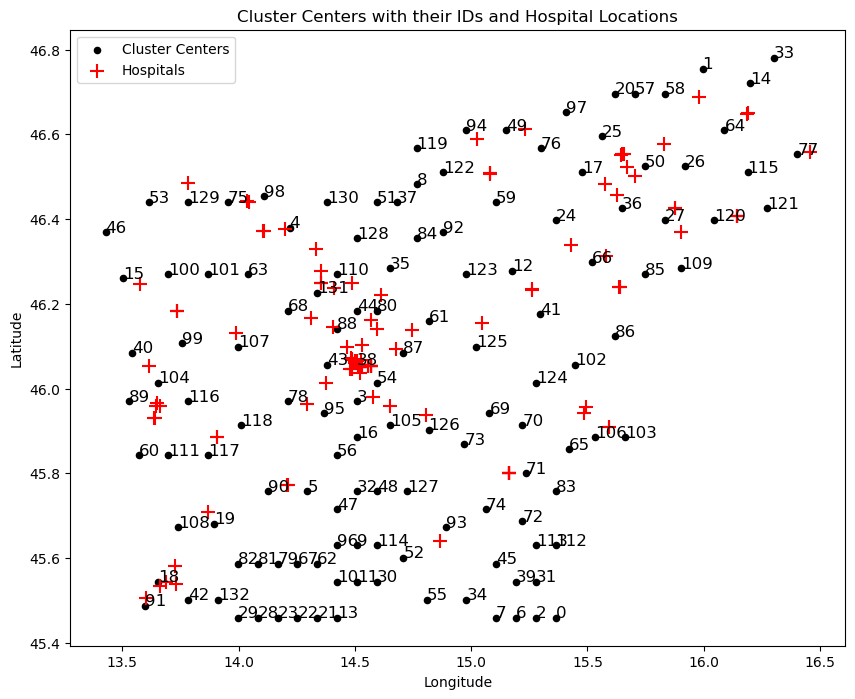

In [35]:
clusters_gdf['x'] = clusters_gdf.geometry.x
clusters_gdf['y'] = clusters_gdf.geometry.y


HealthCenters_centroids['x'] = HealthCenters_centroids.geometry.x
HealthCenters_centroids['y'] = HealthCenters_centroids.geometry.y


fig, ax = plt.subplots(figsize=(10, 8))


ax.scatter(clusters_gdf['x'], clusters_gdf['y'], color='black', marker='o', s=20, label='Cluster Centers')


for x, y, label in zip(clusters_gdf['x'], clusters_gdf['y'], clusters_gdf['cluster']):
    ax.text(x, y, str(label), fontsize=12, color='k')

ax.scatter(HealthCenters_centroids['x'], HealthCenters_centroids['y'], color='red', marker='+', s=100, label='Hospitals')


plt.title("Cluster Centers with their IDs and Hospital Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


### Identify and plot population per healthcare facility

Here, we calculate the urban and rural demand for services for each hospital by summing the populations in each cluster assigned to the hospitals. We also calculate the total demand for each hospital.

In [36]:
# calculateing the total rural and urban demand (population) of each hospital
hospital_population = clusters_gdf.groupby('nearest_hospital_local_id')[['urban_population', 'rural_population']].sum().reset_index()

# now we merge the population data back to the HealthCenters_centroids GeoDataFrame
hospital_population_merged = HealthCenters_centroids.merge(hospital_population, left_on='Local_ID', right_on='nearest_hospital_local_id', how='left')

# also we sum up rural and urban demand to get the total demand of each hospital as well
hospital_population_merged['total_population'] = hospital_population_merged['urban_population'] + hospital_population_merged['rural_population']

# display the demand of hospitals
hospital_population_merged[['Local_ID', 'urban_population', 'rural_population', 'total_population']].sort_values('total_population', ascending=False).dropna()


,Local_ID,urban_population,rural_population,total_population
38,39,167343.843750,0.000000,167343.843750
48,49,46885.500000,70193.351562,117078.851562
25,26,76068.718750,11647.865234,87716.585938
16,17,66169.156250,20895.769531,87064.921875
131,132,47305.285156,29385.140625,76690.421875
...,...,...,...,...
101,102,0.000000,3403.614990,3403.614990
121,122,2615.232422,354.383392,2969.615723
40,41,0.000000,2423.224854,2423.224854
108,109,0.000000,1852.280396,1852.280396


hospital_population_merged.plot('population')

In [37]:
hospital_population_merged.columns

Index(['osm_id', 'osm_way_id', 'name', 'type', 'aeroway', 'amenity',
       'admin_level', 'barrier', 'boundary', 'building', 'craft', 'geological',
       'historic', 'land_area', 'landuse', 'leisure', 'man_made', 'military',
       'natural', 'office', 'place', 'shop', 'sport', 'tourism', 'other_tags',
       'geometry', 'Local_ID', 'x', 'y', 'nearest_hospital_local_id',
       'urban_population', 'rural_population', 'total_population'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


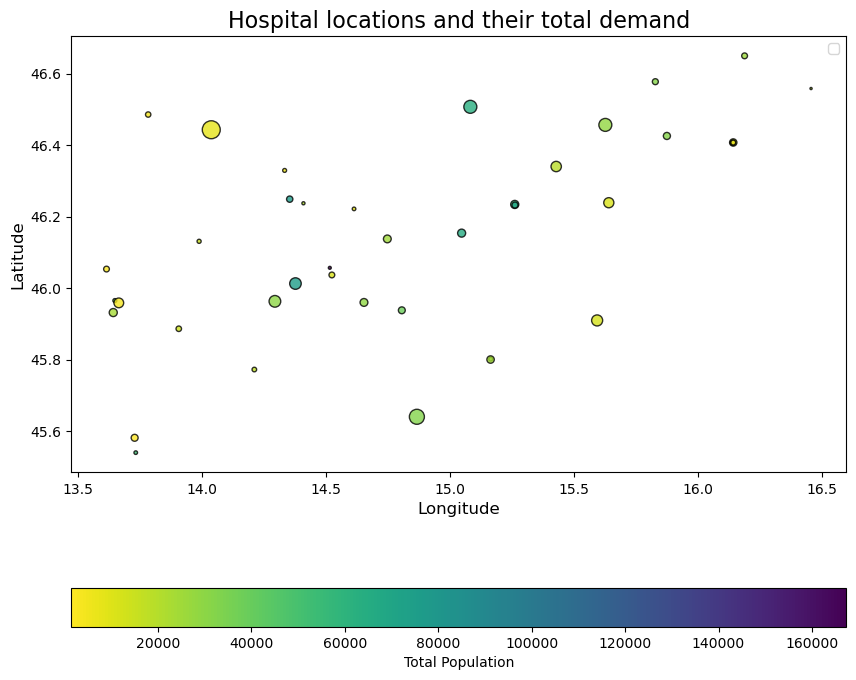

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))


hospital_population_merged.plot(
    ax=ax,
    column='total_population',
    legend=True, 
    legend_kwds={'label': "Total Population", 'orientation': "horizontal"},
    markersize=hospital_population_merged['total_population']/1000 , 
    alpha=0.8,
    cmap='viridis_r',
    edgecolor='black' 
)


# Add a title and labels to the axes
ax.set_title('Hospital locations and their total demand', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend()

# Show the plot
plt.show()


Now we check if there is any hospital that has not been assigned to any population cluster.

In [39]:
assigned_hospitals = clusters_gdf['nearest_hospital_local_id'].unique()

unassigned_hospitals = HealthCenters_centroids[~HealthCenters_centroids['Local_ID'].isin(assigned_hospitals)]

if unassigned_hospitals.empty:
    print("All hospitals are assigned to at least one cluster.")
else:
    print("following hospitals are not assigned to any cluster:")
    print(unassigned_hospitals[['Local_ID', 'geometry']])

following hospitals are not assigned to any cluster:
     Local_ID                   geometry
0           1  POINT (14.52441 46.05365)
2           3  POINT (14.52484 46.06755)
6           7  POINT (14.48788 46.06866)
7           8  POINT (14.48717 46.06762)
8           9  POINT (14.52093 46.05413)
9          10   POINT (14.5237 46.05333)
10         11  POINT (14.52078 46.05266)
11         12  POINT (14.52033 46.05172)
13         14  POINT (14.56972 46.05215)
21         22  POINT (14.52243 46.05235)
22         23  POINT (14.52138 46.05506)
23         24  POINT (14.51099 46.06451)
26         27  POINT (15.87645 46.42654)
28         29   POINT (14.5239 46.05406)
29         30  POINT (14.52124 46.05119)
30         31   POINT (14.5225 46.05157)
31         32  POINT (14.52194 46.05188)
32         33  POINT (14.52217 46.05327)
33         34  POINT (14.52236 46.05607)
34         35  POINT (14.51737 46.05131)
37         38  POINT (14.52526 46.05426)
39         40  POINT (14.52839 46.05496)
43  

## 6. Natural hazard disruption

### Download flood data
The flood data we will extract from a repository maintained by the World Resources Institute. We will download river flood hazard maps from their [Flood Data Collection](https://wri-projects.s3.amazonaws.com/AqueductFloodTool/download/v2/index.html).

Here we do not need to use an API and we also do not need to register ourselves, so we can download any of the files directly. In case you do not have any flood impacts. You could select a more extreme future scenario. But let's first download the 1/1000 river flood event under historic conditions. 

### Overlay flood data with Hospitals

In [41]:
flood_map_path = "https://wri-projects.s3.amazonaws.com/AqueductFloodTool/download/v2/inunriver_historical_000000000WATCH_1980_rp01000.tif"

In [42]:
flood_map = xr.open_dataset(flood_map_path, engine="rasterio")
flood_map

<xarray.Dataset> Size: 4GB
Dimensions:      (band: 1, x: 43200, y: 21600)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 4GB ...

As you can see, this is a very large dataset again. Let's make our life a little bit more relaxed by clipping the map to our country of interest.

In [43]:
min_lon =  country_geom.bounds.minx.values[0]
min_lat = country_geom.bounds.miny.values[0] #complete function
max_lon =  country_geom.bounds.maxx.values[0] #complete function
max_lat =  country_geom.bounds.maxy.values[0]#complete function

flood_map_area = flood_map.rio.clip_box(minx=min_lon,miny=min_lat,maxx=max_lon,maxy=max_lat) #complete function

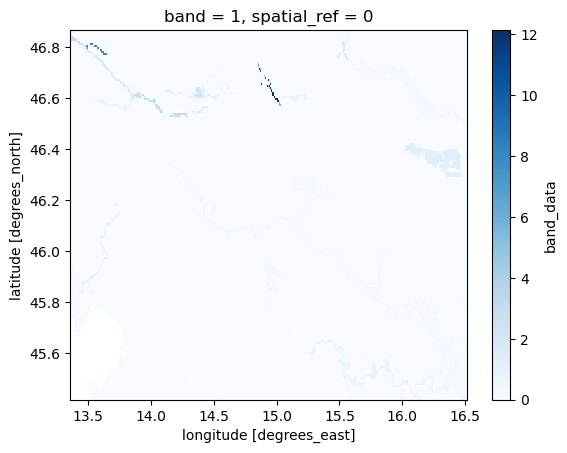

In [44]:
flood_map_area.band_data.plot(cmap='Blues')

### Overlay flood data with healthcare facilities

In [45]:
def _get_damage_per_object(asset, curves, cell_area_m2):
    """
    Calculate damage for a given asset based on hazard information.
    Arguments:
        *asset*: Tuple containing information about the asset. It includes:
            - Index or identifier of the asset (asset[0]).
            - Asset-specific information, including hazard points (asset[1]['hazard_point']).
        *maxdam_dict*: Maximum damage value.
    Returns:
        *tuple*: A tuple containing the asset index or identifier and the calculated damage.
    """

    if asset.geometry.geom_type in ("Polygon", "MultiPolygon"):
        coverage = asset["coverage"] * cell_area_m2
    elif asset.geometry.geom_type in ("LineString", "MultiLineString"):
        coverage = asset["coverage"]
    elif asset.geometry.geom_type in ("Point"):
        coverage = 1
    else:
        raise ValueError(f"Geometry type {asset.geometry.geom_type} not supported")

    return (
        np.sum(
            np.interp(
                asset["values"], curves.index, curves[asset["amenity"]].values
            )
            * coverage
        )
        * asset["maximum_damage"]
    )

In [46]:
maxdam = {"hospital":2000,
        "clinic":1500,
}

curves = np.array(
            [[0,0],
            [50,0.2],
            [100,0.4],
            [150,0.6],
            [200,0.8],
            [250,1]])

curves = np.concatenate((curves,
                            np.transpose(np.array([curves[:,1]]*(len(maxdam)-1)))),
                           axis=1)

curves = pd.DataFrame(curves)
curves.columns = ['depth']+list(maxdam.keys())
curves.set_index('depth',inplace=True)

In [47]:
values_and_coverage_per_object = exact_extract(
            flood_map,
            HealthCenters.to_crs(4326),
            ["coverage", "values"],
            output="pandas",
        )

In [48]:
values_and_coverage_per_object

,coverage,values
0,[0.0031160966027528048],[0.0]
1,[0.008566441014409065],[0.31174808740615845]
2,"[0.012850387953221798, 0.008853942155838013, 0...","[0.0, 0.0, 0.0, 0.0]"
3,[0.00234486092813313],[0.0]
4,[0.00516355037689209],[0.0]
...,...,...
128,[0.0008400809019804001],[0.0]
129,[0.0007367293583229184],[0.0]
130,"[0.00482288608327508, 0.0020372953731566668]","[0.0, 0.0]"
131,[0.0023558475077152252],[0.0]


In [49]:
HealthCenters = HealthCenters.merge(values_and_coverage_per_object,left_index=True,right_index=True)

In [50]:
HealthCenters['maximum_damage'] = HealthCenters.amenity.apply(lambda x: maxdam[x])

In [51]:
HealthCenters['damage'] = HealthCenters.apply(
        lambda _object: _get_damage_per_object(_object, curves, cell_area_m2=100*100),
        axis=1,
    )

In [52]:
HealthCenters['damage'].sort_values(ascending=True)

0         0.000000
93        0.000000
92        0.000000
91        0.000000
90        0.000000
          ...     
76       86.627588
41      148.154755
1       160.234296
120     326.382010
12     2793.266143
Name: damage, Length: 133, dtype: float64

# 7. Your Final Task

As you saw, due to a flood with a 1000-year return period, some hospitals may be out of service. Therefore, we need to estimate the post-flood urban/rural demand for services from the hospitals that remain operational.

### Your task here will be: 
- Create new clusters of populations and assign them to the remaining hospitals, then determine the post-disaster demand for these hospitals.
- Calcuate the urban, rural and total demand (population in need of services) for each hospital.
- Plot the remaining hospitals vs their total population in need of service.
- Let us know how many hospitals were affected by the flood and the total number of rural residents who need to find an alternative hospital.